# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# PATHS

In [2]:
path_data = Path('./input')

In [3]:
path_plots = Path('./plots')

# PLOTS

In [4]:
tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 10, 
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 'xx-small',
        "legend.title_fontsize": 10,
        "xtick.labelsize": 8, #'xx-small',
        "ytick.labelsize": 8, #'xx-small',
        "ps.usedistiller": "xpdf"
        }
plt.rcParams.update(tex_fonts)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,underscore}'

cm=1/2.54

# DATA

In [5]:
transactions = pd.read_csv(
    path_data / 'transactions.csv',
    usecols=['date', 'store_nbr', 'transactions'],
    dtype={'store_nbr': 'category',
           'transactions': 'float32',
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

In [6]:
input_filename = path_data / 'clean_data.gz'
data = pd.read_csv(input_filename, 
                   compression=dict(method='gzip'),
                   index_col='index',
                   dtype={#'store_nbr': 'category',
                          'dayname': 'category',
                         },
                   parse_dates=['date'],
                   infer_datetime_format=True,
                  ) 
data['date'] = pd.to_datetime(data['date'])
'''
csv I/O removes any categorical information (categories and ordering). 
Such info has to be re initialized, or stored in a hdf files
'''
listdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
liststore = list(range(1, 55))
# pd.Categorical() to set the order according to the 'days' list
data.dayname = pd.Categorical(data.dayname, categories=listdays, ordered=True)
data.store_nbr = pd.Categorical(data.store_nbr, categories=liststore, ordered=True)

/tmp/ipykernel_473622/810087225.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_filename,


# FUNCTIONS

In [8]:
def heatmap(piv, xlab, ylab, title, path, filename, cm):
    # piv: pandas pivot table
    # xlab, ylab, title: text as x/y label & title
    # path, filename: to store the figure
    # cm: fig size in cm
    
    fig = plt.figure(figsize=(18*cm, 18*cm))
    
    # mask the upper triangle of the pivot table
    mask = np.triu(piv.corr())
    
    ax = sns.heatmap(piv,
                     annot=False, # True would annotate the values in each individual cell
                     fmt='.1f',
                     cmap='Spectral_r',
                     square=True,
                     mask=mask,
                     linewidths=1,
                     cbar=True,
                     cbar_kws={'location': 'right', 'orientation': 'vertical', 'fraction': 0.025, 'aspect': 30},
                    )
    ax.set(xlabel=xlab, ylabel=ylab, title=title)
    
    plt.show()
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [9]:
def weekly_mean_plot(df, group, col, xlab, ylab, title, legend_title, path, filename, cm):
    
    # df: dataframe. must contain the columns: 'group', 'dayname' and the relevant 'col' column to plot 
    # group: the df column one wants to groupby
    # col: the df column one wants to investigate
    # 'dayname' must be categorical and sorted
    
    temp = df.groupby([str(group), 'dayname'])[col].mean().reset_index().copy()

    df_wide = temp.pivot(index='dayname', columns=str(group), values=col)
    
    
    fig = plt.figure(figsize=(18*cm, 12*cm))
    
    ax = sns.lineplot(data=df_wide, palette='tab20')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    
    ax.legend(title=legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.show()
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [10]:
def barploth(df, group, col, xlab, ylab, title, path, filename, cm):

    # df: dataframe. must contain the columns: group, and col
    # group: the df column one wants to groupby
    # col: the df column one wants to investigate
    
    temp = df.groupby(by=[str(group)])[str(col)].sum().reset_index().sort_values(by=[str(col)], ascending=True).copy()

    fig = plt.figure(figsize=(18*cm, 12*cm))
    
    ax=sns.barplot(data=temp, x=str(col), y=str(group), orient='h', palette='mako')
    # horizontal orientation makes it easier to deal with labels
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    plt.show()
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

# INVESTIGATING STORES

store_nbr       1       2      3       4         5      6            7  \
ind                                                                      
1             0.0     8.0    1.0     6.0   274.830   47.0   737.389000   
2          2293.0     0.0  367.0     0.0   133.000   22.0   225.252990   
3            33.0  2371.0   24.0     3.0   226.384    5.0  5946.388000   
4             0.0   222.0   15.0  3780.0  3983.000  315.0     0.000000   
5            20.0     9.0    3.0     0.0    51.000   20.0    86.076004   

store_nbr        8       9       10  ...        45     46        47      48  \
ind                                  ...                                      
1             8.00  5069.0    2.000  ...  3455.000  113.0   986.000     0.0   
2             0.00     0.0    1.000  ...  3692.000    4.0    40.000    17.0   
3            10.00   707.0    0.000  ...   961.031  886.0    35.000  7417.0   
4             0.00    40.0  137.009  ...   571.000   87.0  1684.396     0.0   
5      

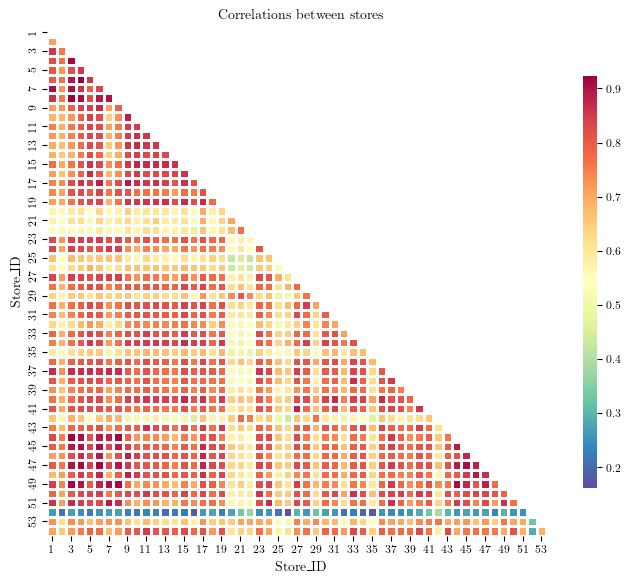

In [11]:
# create pivot table
df_store_nbr = data.loc[:,['store_nbr', 'sales']].copy()
# create an index increasing per entry of 'store_nbr'
# this new index will be used to reshape df_store_nbr via df.pivot
df_store_nbr['ind'] = 1
df_store_nbr['ind'] = df_store_nbr.groupby('store_nbr').ind.cumsum().values
print(df_store_nbr.pivot(index='ind', columns='store_nbr', values='sales').head())
# with such a df, it is possible to compute the correlation between stores
pivot_store_nbr = df_store_nbr.pivot(index='ind', columns='store_nbr', values='sales').corr()

# create heatmap
heatmap(pivot_store_nbr, r'Store\_ID', r'Store\_ID', r'Correlations between stores', path_plots, 'correlations_stores.pdf', cm)

# INVESTIGATING PRODUCTS

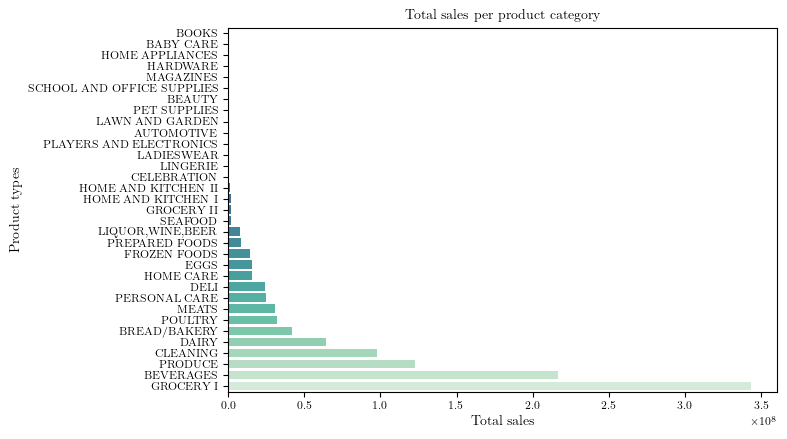

In [12]:
barploth(data, 'family', 'sales', r'Total sales', r'Product types', 'Total sales per product category', \
         path_plots, 'Total sales per product category.pdf', cm)

#### GROCERY I and BEVERAGES are the top-selling products

family  AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
ind                                                                     
1              0.0        0.0    10.0     7125.0    0.0      1269.480   
2              8.0        1.0     5.0     5069.0    0.0       707.000   
3             11.0        0.0     1.0     4753.0    0.0       784.683   
4             13.0        0.0     3.0     1905.0    0.0       230.000   
5             10.0        0.0     7.0     5204.0    0.0       776.350   

family  CELEBRATION  CLEANING   DAIRY     DELI  ...  MAGAZINES    MEATS  \
ind                                             ...                       
1              29.0    1686.0  2644.0  414.664  ...       23.0  566.128   
2              40.0    1054.0  1784.0  205.159  ...       42.0  594.222   
3              36.0    2603.0  1162.0  810.806  ...        3.0   60.519   
4              10.0    1377.0   293.0  243.000  ...       23.0  522.822   
5              18.0    1555.0  1561.0 

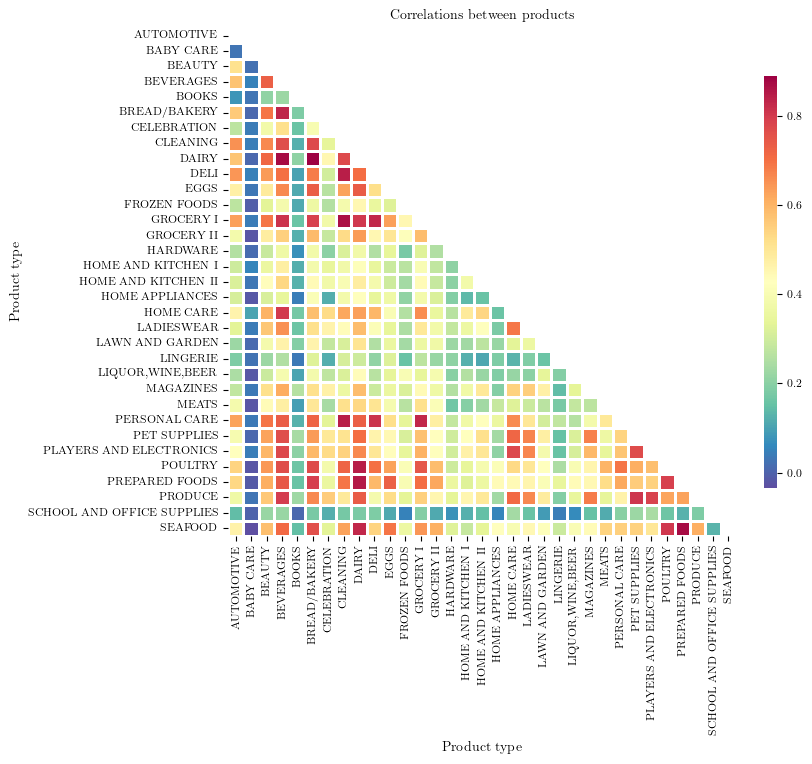

In [13]:
# create pivot table
df_products = data.loc[:,['family', 'sales']].copy()
df_products['ind'] = 1
df_products['ind'] = df_products.groupby('family').ind.cumsum().values
print(df_products.pivot(index='ind', columns='family', values='sales').head())
pivot_product = df_products.pivot(index='ind', columns='family', values='sales').corr()

# create heatmap
heatmap(pivot_product, r'Product type', r'Product type', r'Correlations between products', path_plots, 'correlations_products.pdf', cm)

#### In general product families are not very correlated
#### Some are totally uncorrelated with other products (BABY CARE, BOOKS, SCHOOL AND OFFICE SUPPLIES)
#### Some are strongly or very strongly correlated (GROCERY and BEVERAGES, PRODUCE and HOME CARE, LADIESWEAR and HOME CARE)

# INVESTIGATING SALES

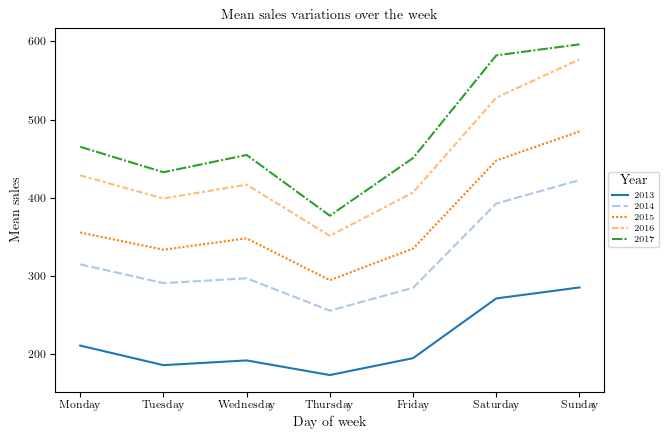

In [14]:
# total sales vs day of week\
weekly_mean_plot(data, 'year', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Year', path_plots, 'weekly_mean_sales_per_year.pdf', cm)    

#### Sales reach a minimum on Thursday, and are maximum over the weekend (no surprise here)

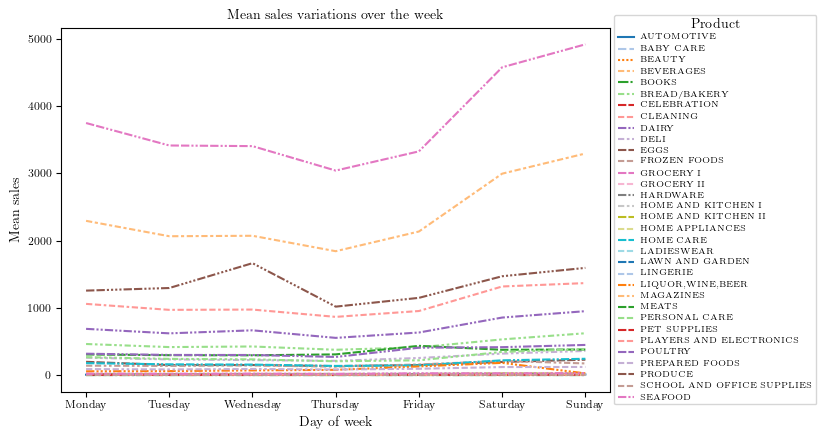

In [15]:
# product sales vs day of week
weekly_mean_plot(data, 'family', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Product', path_plots, 'weekly_mean_sales_per_product.pdf', cm)    

#### However this trend is driven by food products, in particular GROCERY I and BEVERAGES, which have the highest sales
#### Most of the other products do not show a specific trend over the week

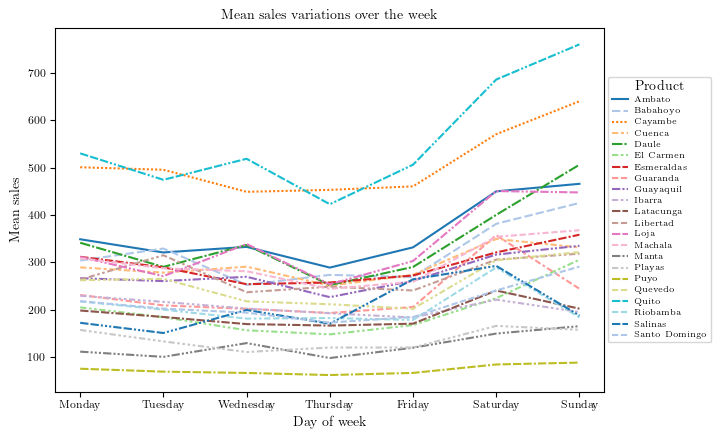

In [16]:
# total sales vs day of week, per city
weekly_mean_plot(data, 'city', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Product', path_plots, 'weekly_mean_sales_per_city.pdf', cm)    

#### The weekly trend varies from city to city (including a Wednesday peak and a (relative) Sunday drop for some.)

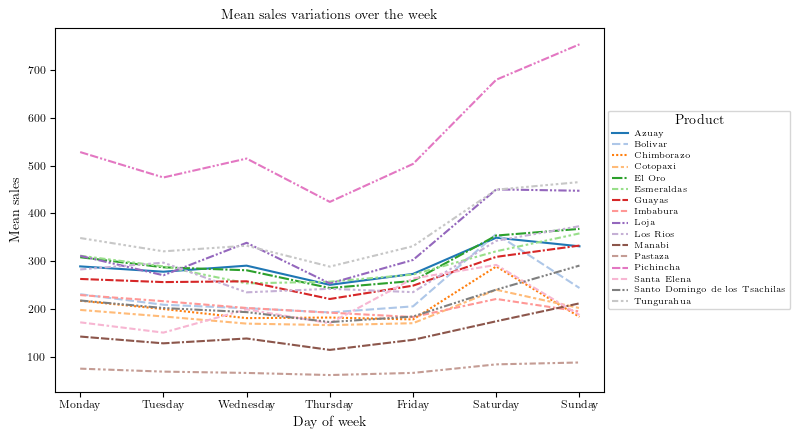

In [17]:
# total sales vs day of week, per state
weekly_mean_plot(data, 'state', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Product', path_plots, 'weekly_mean_sales_per_state.pdf', cm)   

#### Same as above for state trends

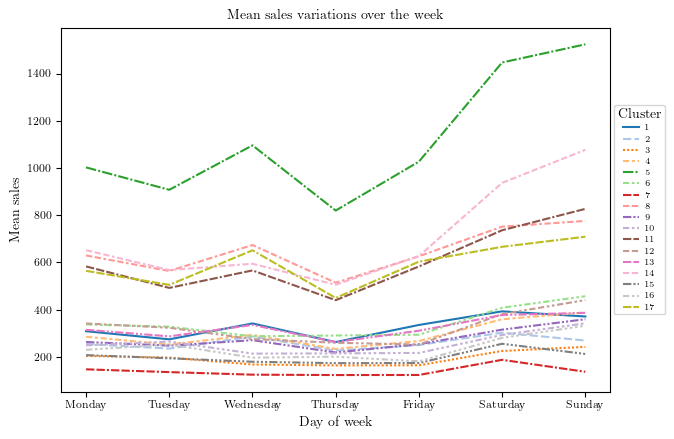

In [18]:
# total sales vs day of week, per cluster
weekly_mean_plot(data, 'cluster', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Cluster', path_plots, 'weekly_mean_sales_per_cluster.pdf', cm)   

#### Same as above for Cluster trends

# Investigating transactions

In [30]:
# load transactions data
transactions = pd.read_csv(
    path_data / 'transactions.csv',
    usecols=['date', 'store_nbr', 'transactions'],
    dtype={#'store_nbr': 'category',
           'transactions': 'float32',
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

transactions['date'] = pd.to_datetime(transactions['date'])

transactions.store_nbr = pd.Categorical(transactions.store_nbr, categories=liststore, ordered=True)
transactions.store_nbr

0        25
1         1
2         2
3         3
4         4
         ..
83483    50
83484    51
83485    52
83486    53
83487    54
Name: store_nbr, Length: 83488, dtype: category
Categories (54, int64): [1 < 2 < 3 < 4 ... 51 < 52 < 53 < 54]

In [31]:
temp = data.groupby(["date", "store_nbr"]).sales.sum().reset_index()
print(len(temp))
temp.head()

90936


,date,store_nbr,sales
0,2013-01-01,1,0.0
1,2013-01-01,2,0.0
2,2013-01-01,3,0.0
3,2013-01-01,4,0.0
4,2013-01-01,5,0.0


In [32]:
# merge sales grouped by date/store_nbr with transactions
transales = temp.merge(transactions, left_on=['date', 'store_nbr'], right_on=['date', 'store_nbr'], how='inner')
print(len(transales))
transales.head()

83488


,date,store_nbr,sales,transactions
0,2013-01-01,25,2511.618999,770.0
1,2013-01-02,1,7417.148000,2111.0
2,2013-01-02,2,10266.718981,2358.0
3,2013-01-02,3,24060.348000,3487.0
4,2013-01-02,4,10200.083980,1922.0


In [33]:
# NOTE THAT SOME SHOPS HAVE O SALES FOR CONSECUTIVE (EARLY) DATES
# PROBABLY THESE SHOPS DID NOT EXIST YET AT THE BEGINNING OF THE EXPERIMENT

In [34]:
def multiyear_data(df, col, group, col_group, xlab, ylab, title, legend_title, path, filename, cm):

    # df: dataframe. must contain a 'date', a 'col', and a 'col_group' column
    # date: self explanatory
    # col: the df column one wants to investigate
    # col_group: the df column used to color code the output
    
    temp = df.groupby(by=[str(group), 'date'])[str(col)].sum().reset_index().copy()  # .sort_values(by=['date'], ascending=True).copy()
   
    fig = plt.figure(figsize=(25*cm, 18*cm))
    
    ax = sns.lineplot(data=df, x='date', y=str(col), hue=str(col_group), palette='tab20')

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend(ncol=3,
              title=legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1)
             )
    
    plt.show()
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

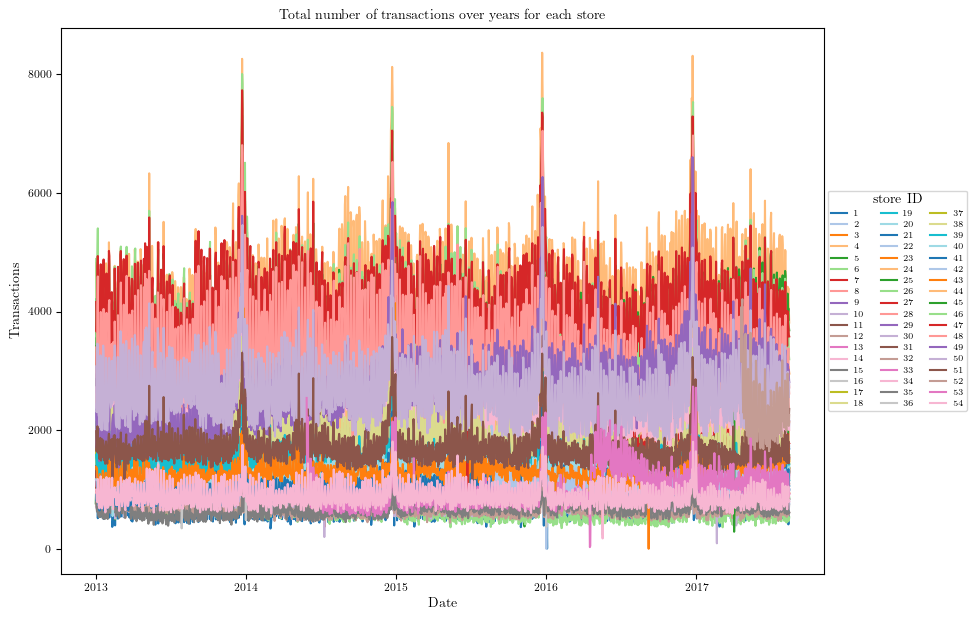

In [35]:
multiyear_data(transales, 'transactions', 'store_nbr', 'store_nbr', r'Date', r'Transactions', \
               r'Total number of transactions over years for each store', r'store ID', path_plots, \
               'transactions_per_store_over_years.pdf', cm)

#### There is a very clear pattern of strongly increased transactions at the end of the year period (Christmas period)

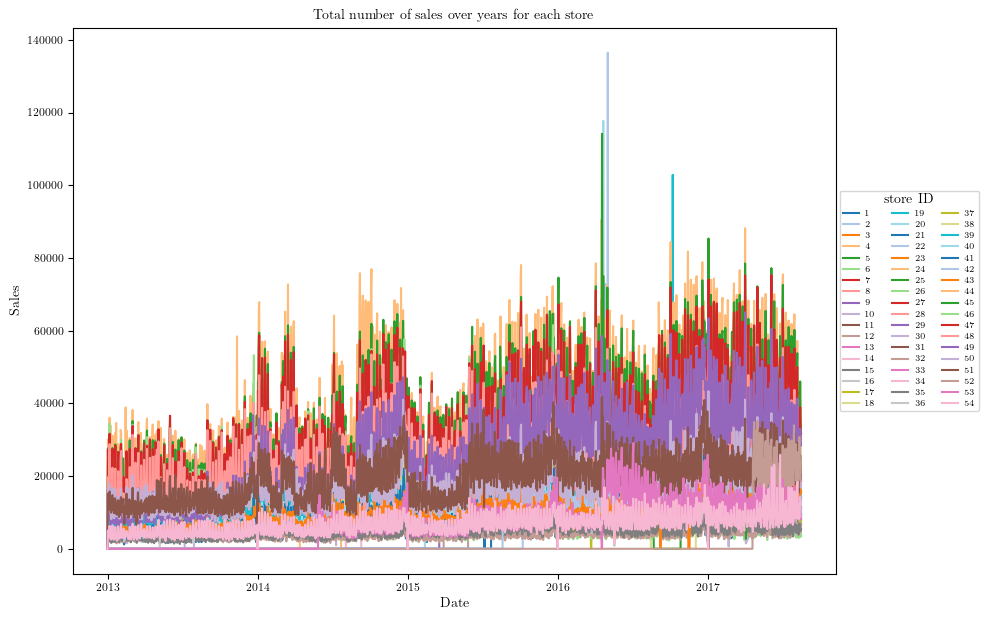

In [36]:
multiyear_data(temp, 'sales', 'store_nbr', 'store_nbr', r'Date', r'Sales', \
               r'Total number of sales over years for each store', r'store ID', path_plots, \
               'sales_per_store_over_years.pdf', cm)

#### This pattern is still present but not so clear when examining the number of sales per store on a multi-year basis

In [37]:
# Pearson correlation coefficient
pearson_corr=transales.sales.corr(transales.transactions, method='pearson')
print('Pearson correlation coefficient: {:,.4f}'.format(pearson_corr))

Pearson correlation coefficient: 0.8374


In [38]:
# Spearman correlation coefficient
spearman_corr=transales.sales.corr(transales.transactions, method='spearman')
print('Spearman correlation coefficient: {:,.4f}'.format(spearman_corr))

Spearman correlation coefficient: 0.8175


#### No surprise to see that sales and transactions are highly correlated

In [64]:
def plot_single_OLS(df, colx, coly, xlab, ylab, title, legend_title, path, filename, cm):
    
    fig = plt.figure(figsize=(18*cm, 9*cm))
       
    ax = sns.regplot(data=df, x=str(colx), y=str(coly), robust=False, \
                   scatter_kws = {'s': 1, 'color': 'dodgerblue',}, \
                   line_kws = {'lw': 2, 'color': 'royalblue',},
                   )

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    plt.show()
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

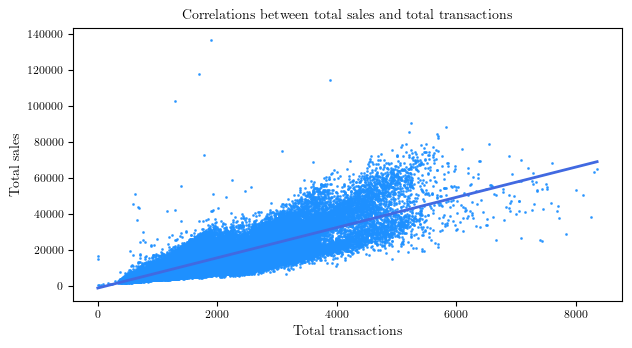

In [65]:
plot_single_OLS(transales, 'transactions', 'sales', r'Total transactions', r'Total sales', \
                'Correlations between total sales and total transactions', None, \
                path_plots, 'correlation_sales_transactions_global.pdf', cm)

#### And this can be seen on a scatter plot

In [106]:
def plot_multiple_OLS(df, colx, coly, colhue, xlab, ylab, title, legend_title, path, filename, cm):
    
    fig = plt.figure(figsize=(18*cm, 9*cm))
    
    fg = sns.lmplot(data=df, x=str(colx), y=str(coly), hue=str(colhue), robust=False, \
                    palette='tab20', 
                    scatter_kws = {'s': 1, },
                    line_kws = {'lw': 2, },
                    facet_kws = {'legend_out': True, },
                    ci=None,
                    legend=False,
                    truncate=True)

    fg.set_axis_labels(x_var=xlab, y_var=ylab)
    fg.set(xlim=(0, None), ylim=(0, None))
    fg.add_legend(title=legend_title) 
    sns.move_legend(fg, "center left", bbox_to_anchor= (1, 0, 0.5, 1), ncol=3)
    
    plt.show()
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

<Figure size 708.661x354.331 with 0 Axes>

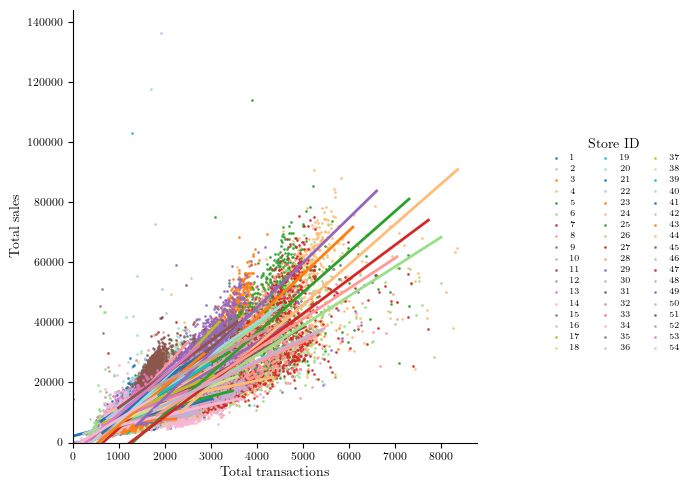

In [107]:
plot_multiple_OLS(transales, 'transactions', 'sales', 'store_nbr', r'Total transactions', r'Total sales', \
                  'Correlations between total sales and total transactions, per store', r'Store ID', \
                  path_plots, 'correlation_sales_transactions_per_store.pdf', cm)

#### as well as on a scatter plot for individual stores

In [20]:
# check where sales are 0

In [21]:
# TBD: Transactions
# peak at end of year ?
# peak at mid/end of month ? 
# transactions vs day of week
# correlation between sales and transactions

In [22]:
# TBD Oil price

In [23]:
# TBD CHECK LAG FEATURES